In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sns
from scipy.stats import median_abs_deviation

#pd.options.display.float_format = '{:.2f}'.format

from model_SARIMA import *
from model_naiv import *
from test_mean import *
from test_correlation import *
from cross_validation import *

warnings.filterwarnings("ignore")

/Users/alex/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Datensatz lesen

In [2]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()

actual_values_dict = {}

for store in range(1, 46):
    store_df = df[df['store'] == store].copy()
    store_df.sort_values('date', inplace=True)
    store_df.set_index('date', inplace=True)

    actual_values_dict[store] = store_df['weekly_sales']

Modell wählen

In [3]:
model_type = 'SARIMA'
#model_type = 'Naive'

Alle Residuen und Fitted Values berechnen

In [4]:
fitted_values_dict = {}
residuals_dict = {}
forecast_dict = {}

if model_type == 'Naive':
    residuals_dict, fitted_values_dict = naive_for_all_stores('Walmart_Sales.csv')

if model_type == 'SARIMA':
    sarima_models, y_test_dict = SARIMA_for_all_stores('Walmart_Sales.csv', whichorder = 70)


Store 1: Modell erstellt mit Order (2, 0, 1) und Seasonal Order (1, 0, 0, 52)
Store 2: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 3: Modell erstellt mit Order (5, 0, 0) und Seasonal Order (0, 0, 2, 52)
Store 4: Modell erstellt mit Order (0, 0, 2) und Seasonal Order (0, 1, 0, 52)
Store 5: Modell erstellt mit Order (2, 0, 1) und Seasonal Order (1, 0, 0, 52)
Store 6: Modell erstellt mit Order (1, 0, 5) und Seasonal Order (1, 0, 0, 52)
Store 7: Modell erstellt mit Order (0, 0, 1) und Seasonal Order (0, 1, 0, 52)
Store 8: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 9: Modell erstellt mit Order (0, 1, 1) und Seasonal Order (1, 0, 0, 52)
Store 10: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 11: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 12: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 13: Modell erstellt mit Order (2, 0, 2) und Seasonal Or

In [5]:
errors_dict = {}

if model_type == 'SARIMA':
    for store in range(1, 46):
        model = sarima_models.get(store)
        fitted_values_dict[store] = model.fittedvalues.iloc[1:]
        residuals_dict[store] = model.resid.iloc[1:]


        forecast_dict[store] = model.get_forecast(steps=43)
        forecast_dict[store] = forecast_dict[store].predicted_mean


        y_pred = forecast_dict[store]
        y_true = y_test_dict[store]


        errors_dict[store] = forecast_dict[store] - y_test_dict[store]

print(len(forecast_dict[2]))

print(len(y_test_dict[2]))
print(len(errors_dict[2].dropna()))
#pd.set_option('display.max_rows', None)
#print(residuals_dict[1])
print(len(residuals_dict[1]))
#print(len(fitted_values_dict[1]))

43
44
43
99


Residuen

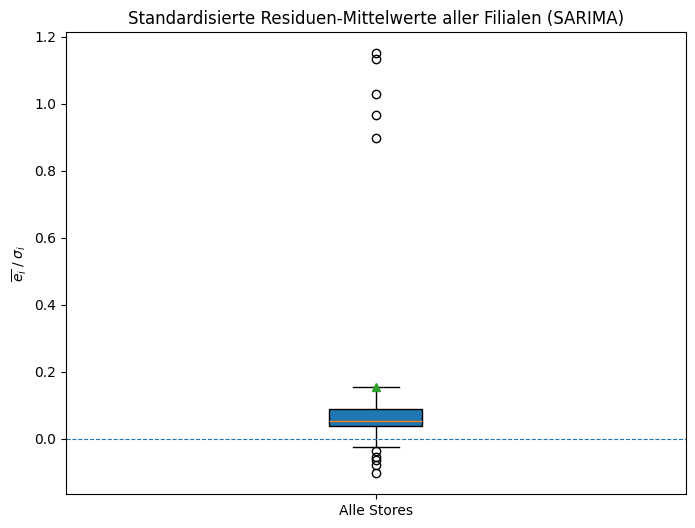

[0.04257806195218261, 0.04212550917521533, 0.035532620472646555, 1.1507238011783258, 0.07503876378493929, -0.011021015060687984, 0.9659694025524008, 0.038321221765876455, 0.039168060055965515, 0.05166890826701782, 0.040235670510164606, 0.05371608634500941, 0.08041740049103183, -0.02309484549376228, 0.0736839133896954, 0.10641540847323275, 0.09702080111366204, 0.05368462123657899, 0.05835464131982214, 0.041048597142131237, 0.0676246702953675, 0.07865613727607425, 0.08642538273638353, 0.05812098301177866, 0.09122993759888963, 0.053799243355098385, 0.04574637322452767, -0.03641073149593433, 0.05006595201060273, -0.06283696216320264, 0.15518081981391596, 0.09051880795529373, -0.052510530845599354, 0.1036055456806939, 0.02020468720501444, -0.10252970568121351, 1.0282296958691293, -0.07879054839012464, 0.05022865760123802, 0.08911744168093345, 0.07123005108422938, 1.1346630678489338, 0.8979193832187887, -0.0021507807598363867, 0.0661443432046069]
Mittelwert:  0.15366821222237861
Median:  0.0

In [6]:
resid_bias = [] 
for store in sorted(residuals_dict.keys(), key=int):
    resid = residuals_dict[store]
    mean = resid.mean()
    std = resid.std(ddof=0)        # Populations-Std (ddof=0)
    if std == 0:
        resid_bias.append(np.nan)
    else:
        resid_bias.append(mean / std) # standardisierter Bias

# Erstelle den Boxplot der Mittelwerte
plt.figure(figsize=(8, 6))
plt.boxplot(resid_bias, patch_artist=True, showmeans=True)
plt.title('Standardisierte Residuen-Mittelwerte aller Filialen ({})'.format(model_type))
plt.ylabel(r'$\overline{e_i}\; / \;\sigma_i$')
plt.xticks([1], ["Alle Stores"])
plt.axhline(0, ls='--', lw=0.8)
plt.show()

print(resid_bias)
print("Mittelwert: ", np.mean(resid_bias))
print("Median: ", np.median(resid_bias))

Korrelations Tests

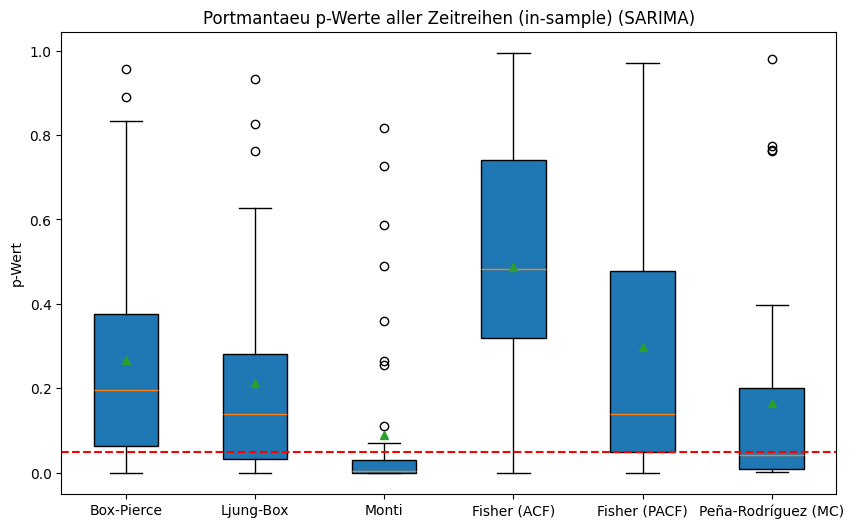

Mittelwerte: 0.2674054211548634 0.2127517886021322 0.08907646354287788 0.4883351712946992 0.29869419740864556 0.1646797646797647
Mediane: 0.19715774419744095 0.138646484624803 0.004261364239795951 0.4819713017862959 0.13880732124115702 0.04295704295704296


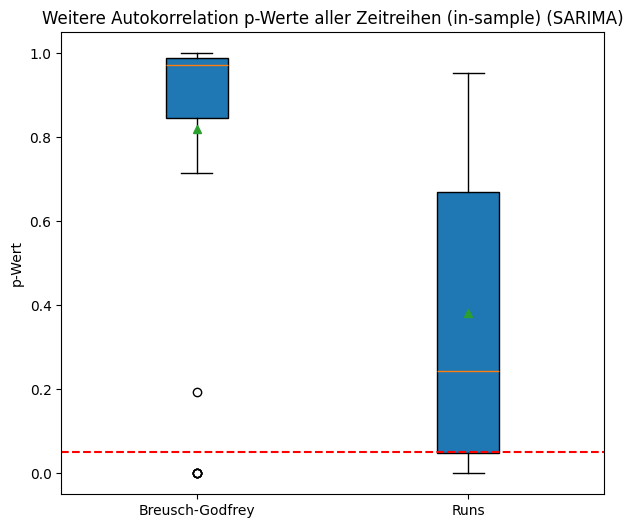

Mittelwerte: 0.8206438150206075 0.3806868706480602
Mediane: 0.971613398819088 0.24316156068912176


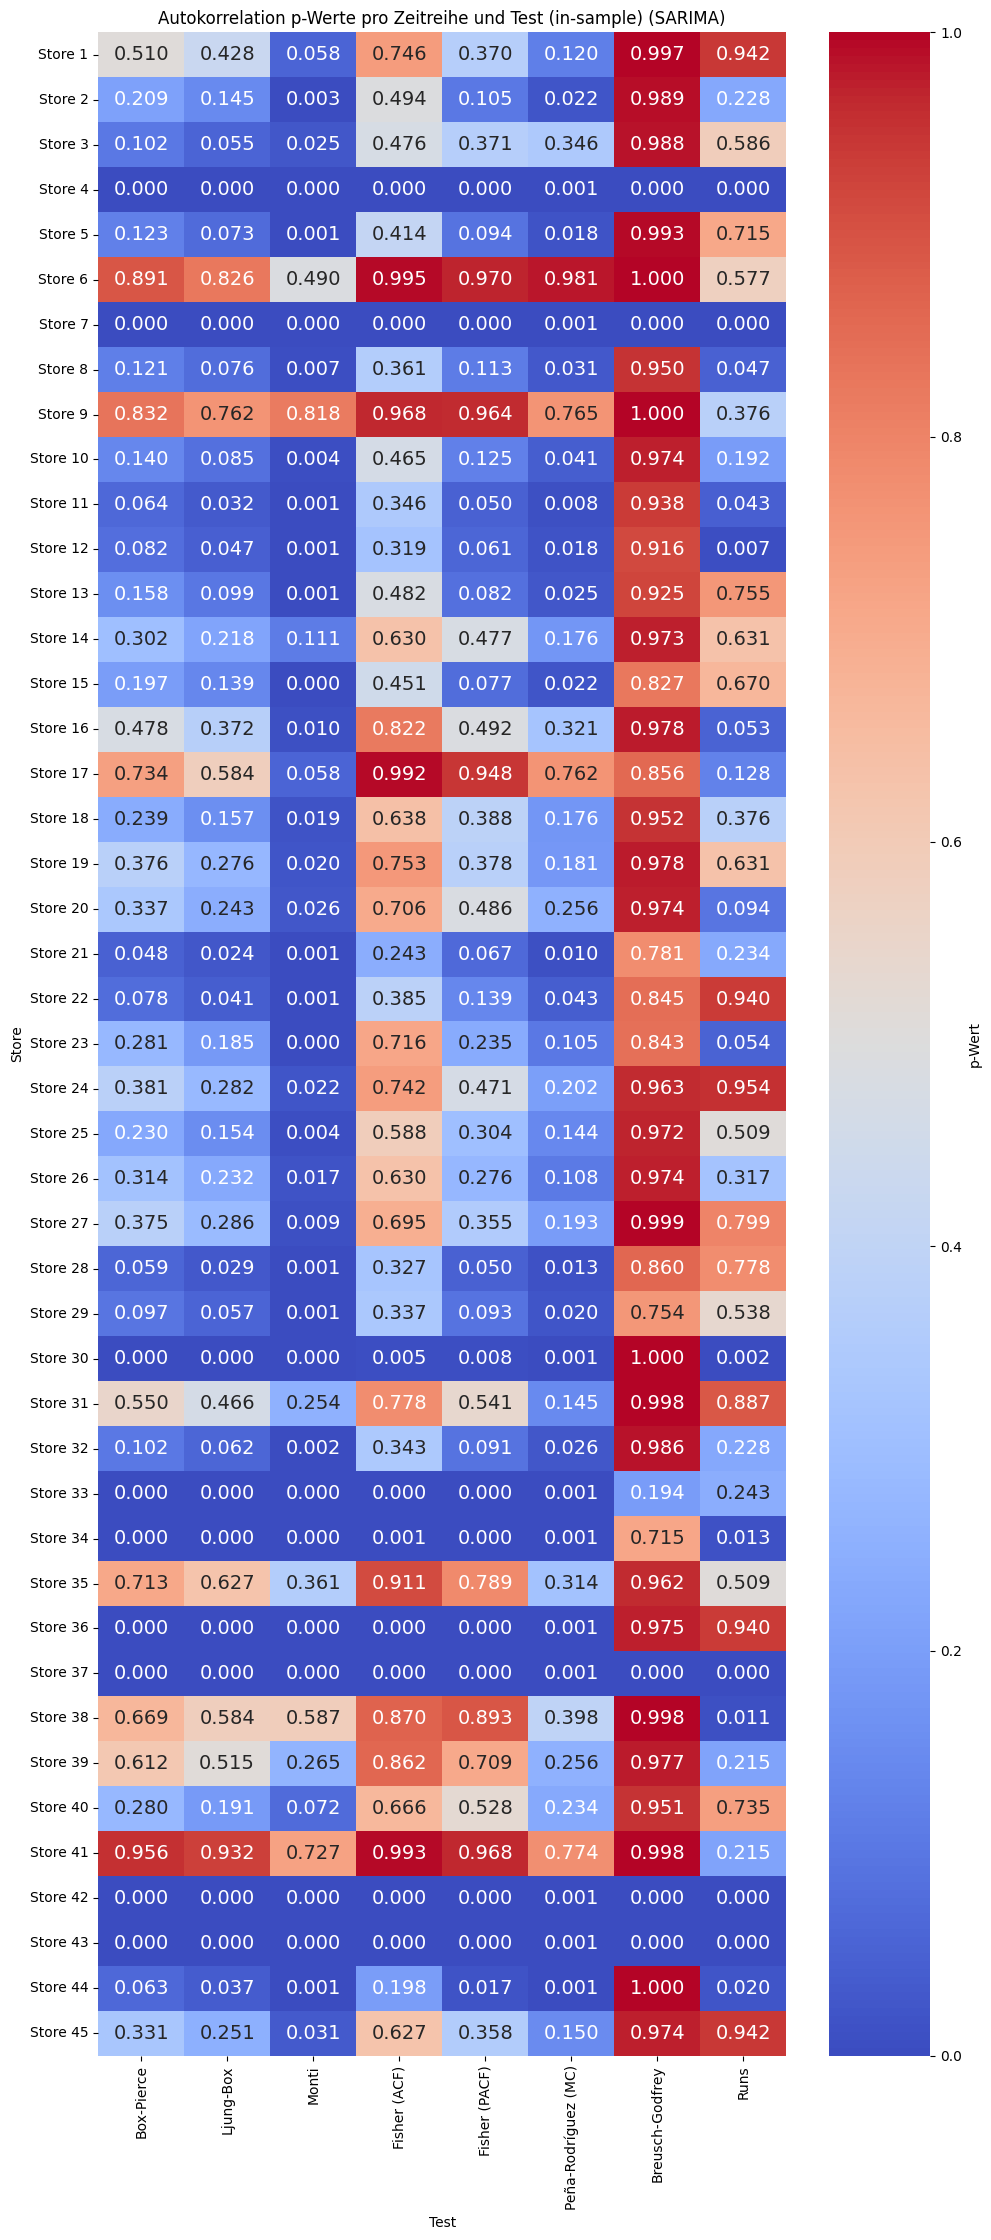

In [7]:
bp_pvalues = []
lb_pvalues = []
bg_pvalues = []
rt_pvalues = []
m_pvalues = []
f_pvalues = []
f2_pvalues = []
pr2_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store) #Residuen für den Store

    sales = df[df['store'] == store].copy() #Zeitreihe für den Store
    sales.set_index('date', inplace=True)
    sales = sales['weekly_sales']
    sales = sales.asfreq('W-FRI')

    if resid is not None:
        # Box-Pierce Test
        try:
            _, p_value = box_pierce_test(residuals = resid, store_num = store, model = model_type, sample = "IS", lags = 20, print_results=False)
            bp_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Box-Pierce Test für Store {store}: {e}")
            bp_pvalues.append(np.nan)
        # Ljung-Box Test
        try:
            _, p_value = ljung_box_test(residuals = resid, store_num = store, model = model_type, sample = "IS", lags=20, print_results = False)
            lb_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Ljung-Box Test für Store {store}: {e}")
            lb_pvalues.append(np.nan)
        # Breusch-Godfrey Test
        try:
            if model_type == 'SARIMA':
                _, p_value = breusch_godfrey_test(model = sarima_models[store], lags = 20, print_results = False)
            if model_type == 'Naive':
                _, p_value = breusch_godfrey_test_naive(sales, lags = 5, print_results = False)
            bg_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Breusch-Godfrey Test für Store {store}: {e}")
            bg_pvalues.append(np.nan)
        # Monti Test
        try:
            _, p_value = monti_test(residuals = resid, store_num=store, model = model_type, m = 20, print_results = False)
            m_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Monti Test für Store {store}: {e}")
            m_pvalues.append(np.nan)
        # Fisher Test (ACF)
        try:
            _, p_value = fisher_test(residuals = resid, store_num = store, model = model_type, version = "acf", m = 20, print_results = False)
            f_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Fisher Test für Store {store}: {e}")
            f_pvalues.append(np.nan)
        # Fisher Test (PACF)
        try:
            _, p_value = fisher_test(residuals = resid, store_num = store, model = model_type, version = "pacf", m = 20, print_results = False)
            f2_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Fisher Test für Store {store}: {e}")
            f2_pvalues.append(np.nan)
        # Pena Rodriguez Test (Monte Carlo)
        try:
            _, p_value = pena_rodriguez_test_mc(residuals = resid, m = 20, print_results= False)
            pr2_pvalues.append(p_value)

        except Exception as e:
            print(f"Fehler beim Pena Rodriguez Test für Store {store}: {e}")
            pr2_pvalues.append(np.nan)

        # Runs Test
        try:
            _, p_value = run_test(residuals = resid, print_results = False)
            rt_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Runs Test für Store {store}: {e}")
            rt_pvalues.append(np.nan)
    else:
        bp_pvalues.append(np.nan)
        lb_pvalues.append(np.nan)
        bg_pvalues.append(np.nan)
        rt_pvalues.append(np.nan)
        m_pvalues.append(np.nan)
        f_pvalues.append(np.nan)
        f2_pvalues.append(np.nan)
        pr2_pvalues.append(np.nan)



pvalues = np.column_stack([bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr2_pvalues, bg_pvalues, rt_pvalues])
pvalues_portmantaeu = np.column_stack([bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr2_pvalues])
pvalues_other = np.column_stack([bg_pvalues, rt_pvalues])


# Boxplot Portmanteau
plt.figure(figsize=(10, 6))
plt.boxplot(pvalues_portmantaeu, patch_artist=True, showmeans=True)
plt.title('Portmantaeu p-Werte aller Zeitreihen (in-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4, 5, 6], ["Box-Pierce", "Ljung-Box",  "Monti", "Fisher (ACF)", "Fisher (PACF)", "Peña-Rodríguez (MC)"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.show()

# Mittelwerte und Median der p-Werte
print("Mittelwerte:", np.mean(bp_pvalues), np.mean(lb_pvalues),  np.mean(m_pvalues), np.mean(f_pvalues), np.mean(f2_pvalues), np.mean(pr2_pvalues))
print("Mediane:", np.median(bp_pvalues), np.median(lb_pvalues),  np.median(m_pvalues), np.median(f_pvalues), np.median(f2_pvalues), np.median(pr2_pvalues))

# Boxplot Breusch-Godfrey und Runs-Test
plt.figure(figsize=(7, 6))
plt.boxplot(pvalues_other, patch_artist=True, showmeans=True, widths=[0.23, 0.23])
plt.title('Weitere Autokorrelation p-Werte aller Zeitreihen (in-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2], ["Breusch-Godfrey", "Runs"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.show()

# Mittelwerte und Median der p-Werte
print("Mittelwerte:", np.mean(bg_pvalues), np.mean(rt_pvalues))
print("Mediane:", np.median(bg_pvalues), np.median(rt_pvalues))


# Heatmap
store_names = [f"Store {i+1}" for i in range(pvalues.shape[0])]
columns = ["Box-Pierce", "Ljung-Box",  "Monti", "Fisher (ACF)", "Fisher (PACF)", "Peña-Rodríguez (MC)", "Breusch-Godfrey", "Runs"]
df_pvalues = pd.DataFrame(pvalues, index=store_names, columns=columns)
plt.figure(figsize=(10, len(store_names) * 0.5))  # Dynamische Höhe
sns.heatmap(df_pvalues, annot=True, fmt=".3f", annot_kws={"size": 14}, cmap="coolwarm", cbar_kws={'label': 'p-Wert'}, vmin=0, vmax=1)
plt.title('Autokorrelation p-Werte pro Zeitreihe und Test (in-sample) ({})'.format(model_type))
plt.xlabel("Test")
plt.ylabel("Store")
plt.tight_layout()
plt.show()





Durbin Watson

[2.0322854936903503, 1.8318644589001882, 1.9132753384795216, 0.08957816471754557, 2.024370020309847, 1.9702076654788983, 0.7243254463694946, 1.8060785589188815, 2.0953307730674635, 1.8731698364165632, 1.8013883626645342, 1.8613676045577185, 1.8356430909408732, 1.919124922729754, 1.8788956471986495, 1.920454729475074, 1.9453461606468239, 1.8645767548075087, 1.7998977229978212, 1.77684385897018, 1.886507112481631, 1.8630971683156619, 1.8602438030781583, 1.9316038156904414, 1.8596688212263097, 1.8143864261504061, 1.8405171965983604, 1.836472342193432, 2.07716139544867, 2.628363925375534, 2.0668676154952244, 1.8199264859002373, 2.361104494028315, 2.7706712908847737, 2.002322557497815, 2.361341331785819, 0.021707179631344234, 2.4539936779315035, 1.9853138821802752, 2.0954458373966998, 2.0024595925042505, 0.028651749309258453, 0.04320091282049553, 2.6558427963572586, 1.8184775744894817]


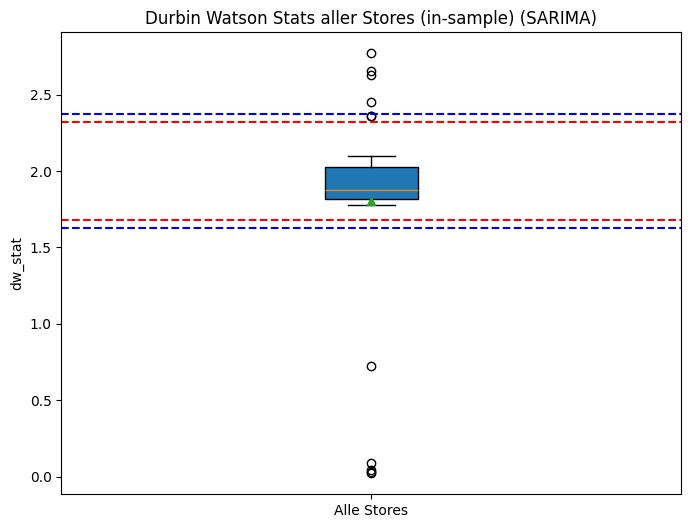

Mittelwert: 1.8010971910246456
Median: 1.8788956471986495


In [8]:
dw_stats = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        try:
            dw_stat = durbin_watson_test(resid, False)
            dw_stats.append(dw_stat)
        except Exception as e:
            print(f"Fehler beim Durbin Watson Test für Store {store}: {e}")
            dw_stats.append(np.nan)
    else:
        dw_stats.append(np.nan)

print(dw_stats)

# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(dw_stats, patch_artist=True, showmeans=True)
plt.title('Durbin Watson Stats aller Stores (in-sample) ({})'.format(model_type))
plt.ylabel("dw_stat")
plt.xticks([1], ["Alle Stores"])
plt.axhline(1.68, color='red', linestyle='--', label='dU')
plt.axhline(4-1.68, color='red', linestyle='--', label='4-dU')
plt.axhline(1.63, color='blue', linestyle='--', label='dL')
plt.axhline(4-1.63, color='blue', linestyle='--', label='4-dL')
plt.show()

# Mittelwerte und Median der p-Werte
print("Mittelwert:", np.mean(dw_stats))
print("Median:", np.median(dw_stats))


ACF Plots

[2, 2, 1, 18, 2, 0, 18, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 1, 2, 3, 1, 2, 14, 3, 1, 12, 18, 1, 1, 1, 1, 18, 18, 1, 1]
45


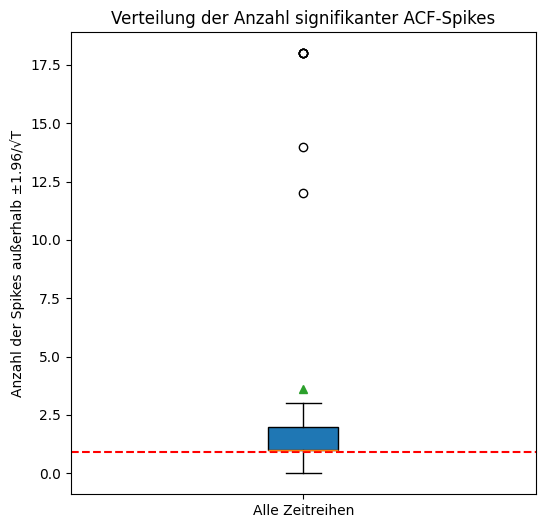

In [9]:

spikes = {}
for store in range(1, 46):
    resid = residuals_dict.get(store)
    count_spikes(resid, lags = 18)
    spikes[store] = count_spikes(resid, lags = 18)
    #print(spikes[store])


values = list(spikes.values())
print(values)
print(len(values))

plt.figure(figsize=(6, 6))
plt.boxplot(values, patch_artist=True, showmeans=True)
plt.title("Verteilung der Anzahl signifikanter ACF-Spikes")
plt.ylabel("Anzahl der Spikes außerhalb ±1.96/√T")
plt.xticks([1], ["Alle Zeitreihen"])
plt.axhline(18*0.05, color='red', linestyle='--')
plt.show()



Mittelwert Tests

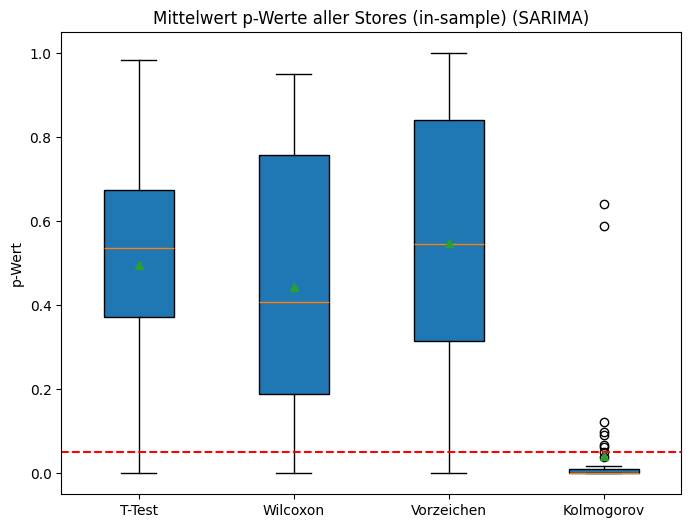

Mittelwerte: 0.49613769225971277 0.4443634078549522 0.5481502480880812 0.04115677639208636
Mediane: 0.5353508080469501 0.40680972734000803 0.5467134835988133 0.0012976506493445061


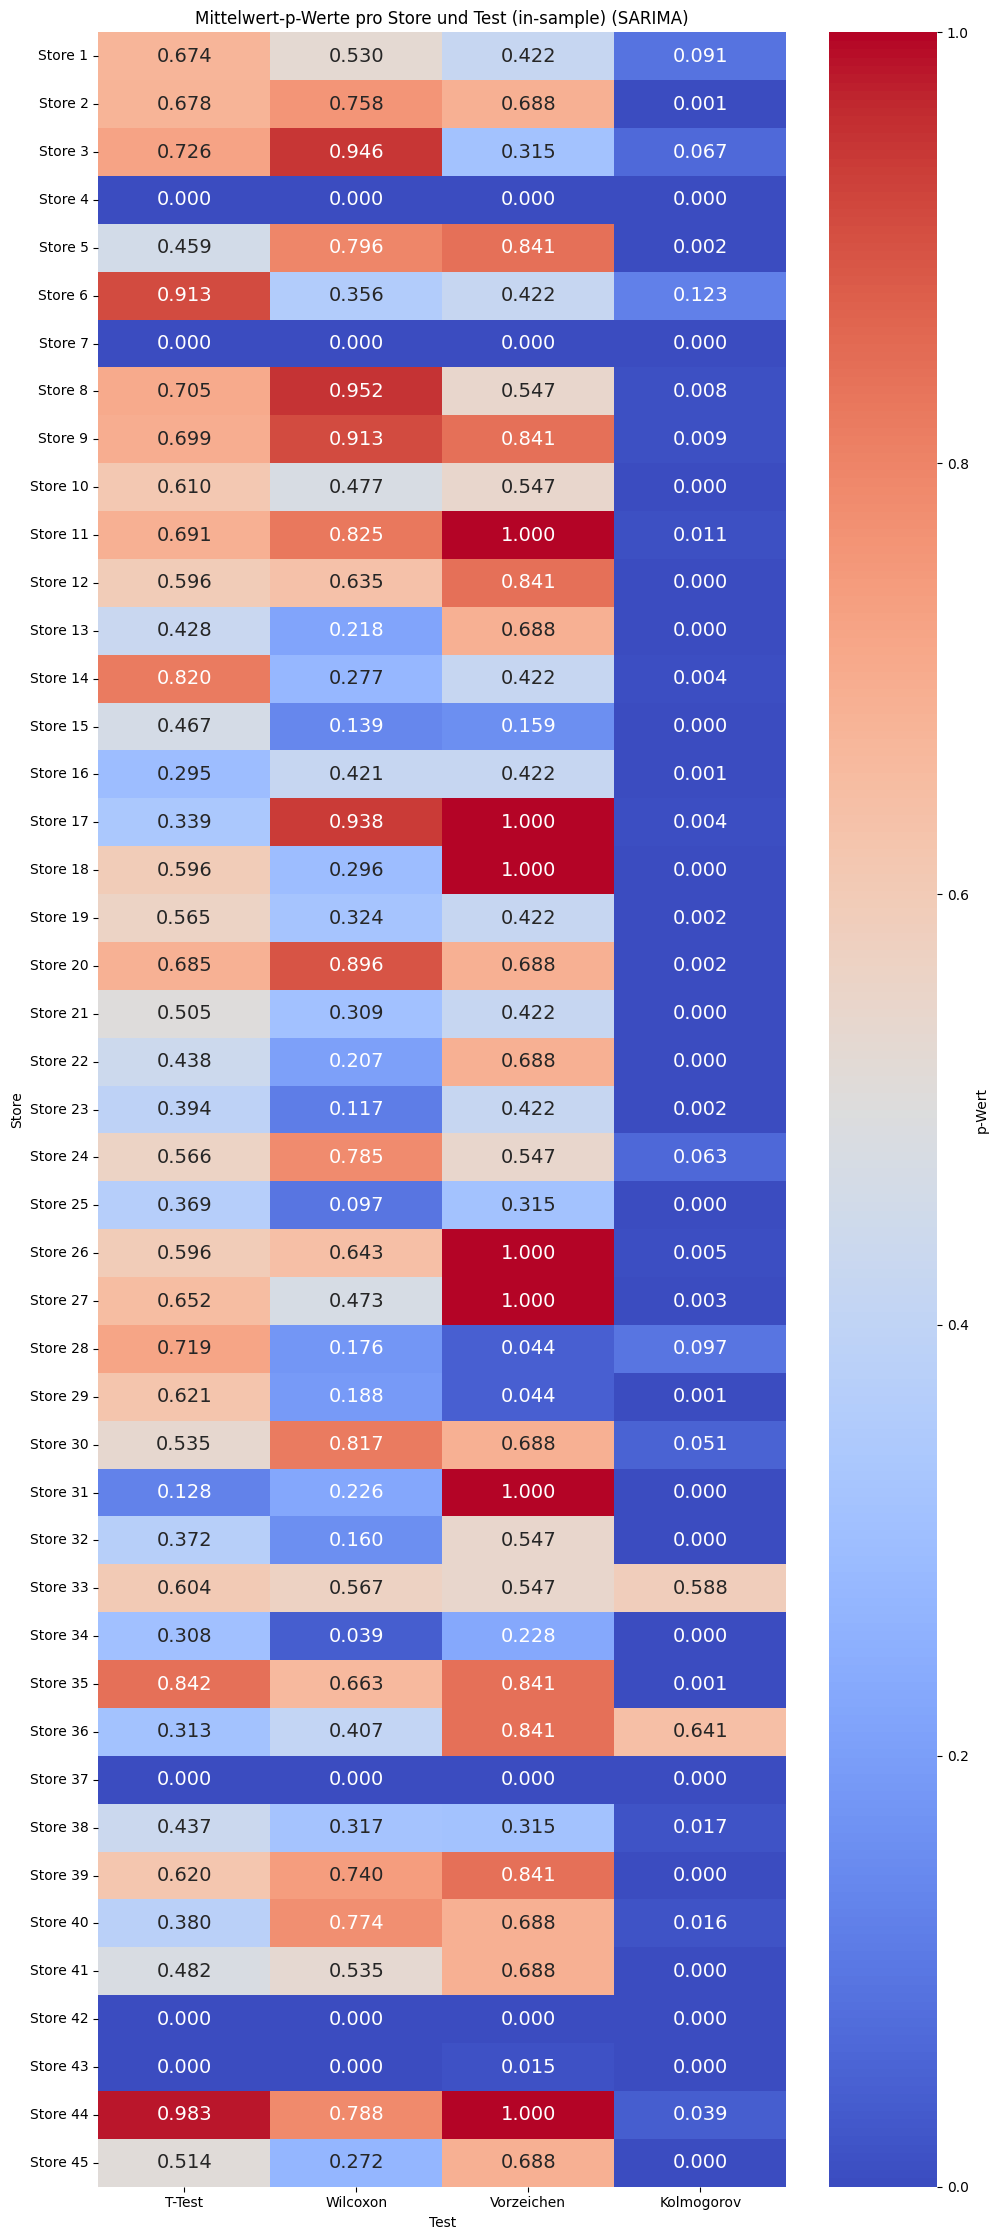

In [10]:
t_pvalues = []
w_pvalues = []
b_pvalues = []
k_pvalues = []
z_pvalues = []
s_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        # T-Test
        try:
            _, p_value = t_test(resid, False)
            t_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim t-Test für Store {store}: {e}")
            t_pvalues.append(np.nan)
        # Wilcoxon Test
        try:
            _, p_value = wilcoxon_test(resid, False)
            w_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Wilcoxon Test für Store {store}: {e}")
            w_pvalues.append(np.nan)
        # Binomial Test
        try:
            _, _, p_value = binomial_test(resid, False)
            b_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Binomial Test für Store {store}: {e}")
            b_pvalues.append(np.nan)
        # Sign Test
        try:
            _, s_value = vorzeichen_test(resid, False)
            s_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Sign Test für Store {store}: {e}")
            s_pvalues.append(np.nan)
        # Kolmogorov Test
        try:
            _, p_value = kolmogorov_test(resid, False)
            k_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Kolmogorov Test für Store {store}: {e}")
            k_pvalues.append(np.nan)
        # Z-Test
        try:
            _, p_value = z_test(resid, False)
            z_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Z-Test für Store {store}: {e}")
            z_pvalues.append(np.nan)
    else:
        t_pvalues.append(np.nan)
        w_pvalues.append(np.nan)
        b_pvalues.append(np.nan)
        k_pvalues.append(np.nan)
        z_pvalues.append(np.nan)


pvalues = np.column_stack([t_pvalues, w_pvalues, s_pvalues, k_pvalues])


# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues, patch_artist=True, showmeans=True)
plt.title('Mittelwert p-Werte aller Stores (in-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4], ["T-Test", "Wilcoxon", "Vorzeichen","Kolmogorov"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.show()

# Mittelwerte und Median der p-Werte
print("Mittelwerte:", np.mean(t_pvalues), np.mean(w_pvalues), np.mean(s_pvalues), np.mean(k_pvalues))
print("Mediane:", np.median(t_pvalues), np.median(w_pvalues), np.median(s_pvalues), np.median(k_pvalues))


# Heatmap
store_names = [f"Store {i+1}" for i in range(pvalues.shape[0])]
columns = ["T-Test", "Wilcoxon", "Vorzeichen", "Kolmogorov"]
df_pvalues = pd.DataFrame(pvalues, index=store_names, columns=columns)
plt.figure(figsize=(10, len(store_names) * 0.5))  # Dynamische Höhe
sns.heatmap(df_pvalues, annot=True, fmt=".3f", annot_kws={"size": 14}, cmap="coolwarm", cbar_kws={'label': 'p-Wert'}, vmin=0, vmax=1)
plt.title('Mittelwert-p-Werte pro Store und Test (in-sample) ({})'.format(model_type))
plt.xlabel("Test")
plt.ylabel("Store")
plt.tight_layout()
plt.show()

SMAPE

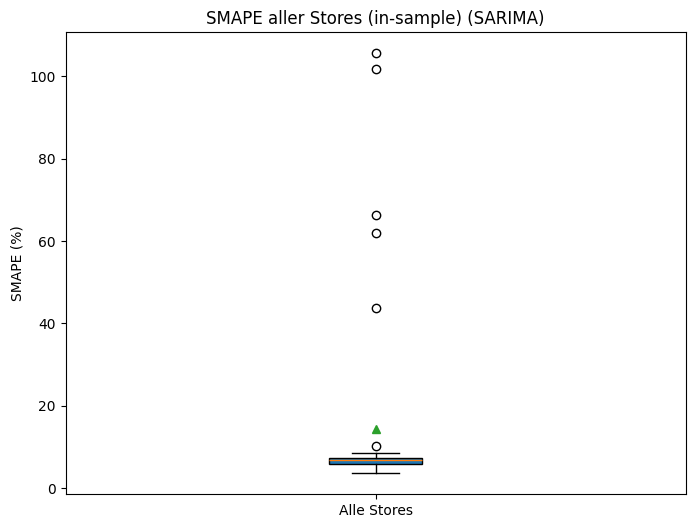

Mittelwert: 14.290722772570616 %
Median: 6.744242605476547 %
[5.340887827106428, 5.570973762357464, 5.869182709223504, 66.46836036359484, 5.734765584255979, 6.51788165028907, 43.83446654363462, 5.614791671708987, 6.96686878678198, 5.87312782023177, 6.108987633881199, 5.946098438371357, 5.7262876392741955, 7.27614964684393, 7.431086526688503, 6.642597505398952, 8.122223817727491, 8.150277464508129, 6.441625469730031, 6.746203979040046, 7.1135625057326815, 6.988348700719148, 8.414609399437435, 6.744242605476547, 6.312627650022205, 6.196873855896265, 7.411740951669488, 8.474542238658806, 7.857015636648608, 3.6171439180847162, 5.970499824426546, 4.991063039846791, 7.351404754983049, 5.786081297643708, 10.320371498703663, 4.9511036527635985, 101.7762601287915, 5.874528246134306, 7.206068675506788, 6.715294261905928, 7.41774798249631, 105.63917036666928, 62.001013951287476, 4.673807317764492, 6.894557463759875]


In [11]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()

smape_stats = []

for store_id in range(1, 46):
    # fitted_values holen und in Serie umwandeln
    fitted = fitted_values_dict.get(store_id)
    if fitted is None:
        smape_stats.append(np.nan)
        continue

    # Sales-Daten für den Store
    store_df = df[df['store'] == store_id].copy()
    store_df.set_index('date', inplace=True)
    sales = store_df['weekly_sales'].asfreq('W-FRI')

    # fitted in Serie mit gleichem Index überführen
    y_pred = pd.Series(fitted, index=sales.index, name='pred')
    y_true = sales.rename('true')

    # nur Wochen, wo beide Werte vorliegen
    mask = y_pred.notna() & y_true.notna()

    y_pred_clean = y_pred[mask]
    y_true_clean = y_true[mask]

    # SMAPE
    numerator   = np.abs(y_pred_clean - y_true_clean)
    denominator = (np.abs(y_pred_clean) + np.abs(y_true_clean)) / 2

    smape_array = np.where(denominator == 0, 0, numerator / denominator)
    smape = np.nanmean(smape_array) * 100

    #print(len(smape_array))
    smape_stats.append(smape)


# Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(smape_stats, patch_artist=True, showmeans=True)
plt.title(f'SMAPE aller Stores (in-sample) ({model_type})')
plt.ylabel("SMAPE (%)")
plt.xticks([1], ["Alle Stores"])
plt.show()

# Mittelwerte und Median der SMAPE Werte
print("Mittelwert:",np.mean(smape_stats), "%")
print("Median:",np.median(smape_stats), "%")
print(smape_stats)

SMAPE vs. Autokorrelation p-Werte

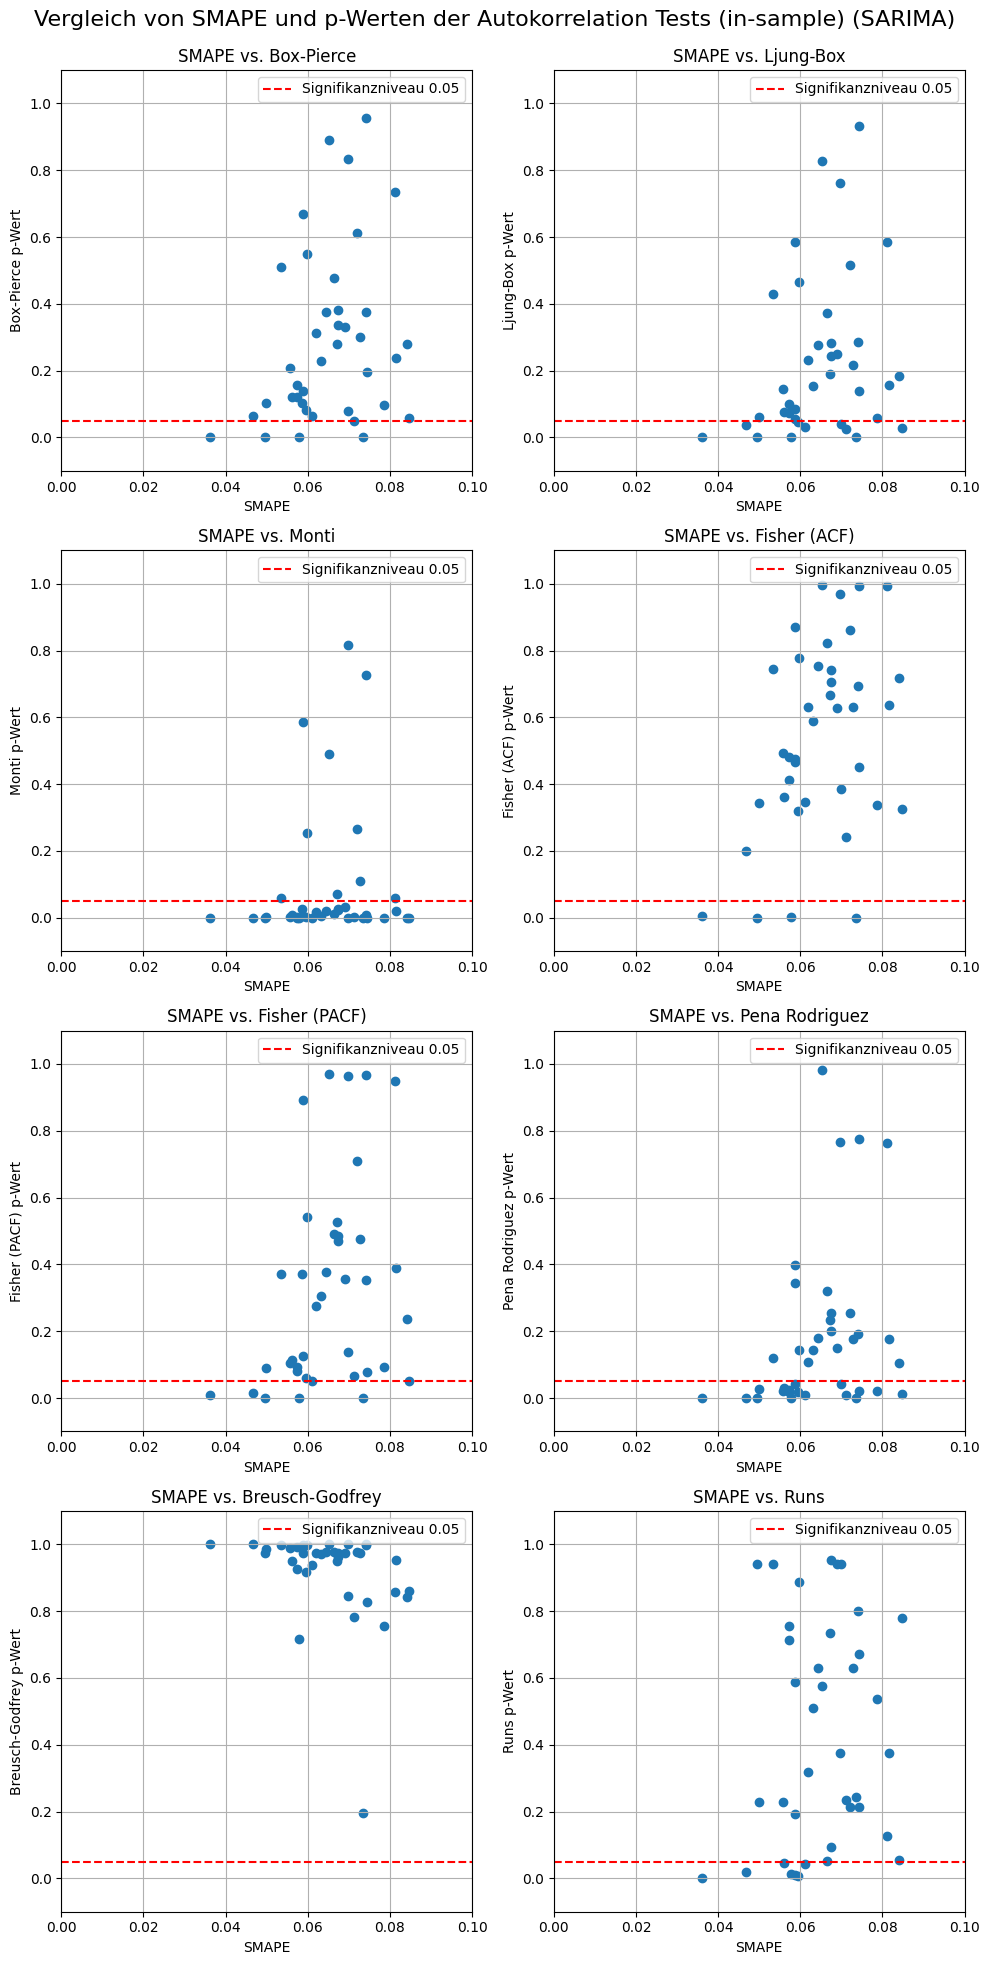

In [12]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))  # 2 Zeilen, 4 Spalten

smape_dec = np.asarray(smape_stats) / 100
p_values_list = [bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr2_pvalues, bg_pvalues, rt_pvalues]
test_names = ["Box-Pierce", "Ljung-Box", "Monti", "Fisher (ACF)", "Fisher (PACF)", "Pena Rodriguez", "Breusch-Godfrey", "Runs"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_dec, p_values_list[i])
    ax.set_xlabel('SMAPE')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'SMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
    ax.legend()
    ax.set_xlim(0, 0.1)
    ax.set_ylim(-0.1, 1.1)


fig.suptitle('Vergleich von SMAPE und p-Werten der Autokorrelation Tests (in-sample) ({})'.format(model_type), fontsize=16)
plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

SMAPE vs Mittelwert p-Werte

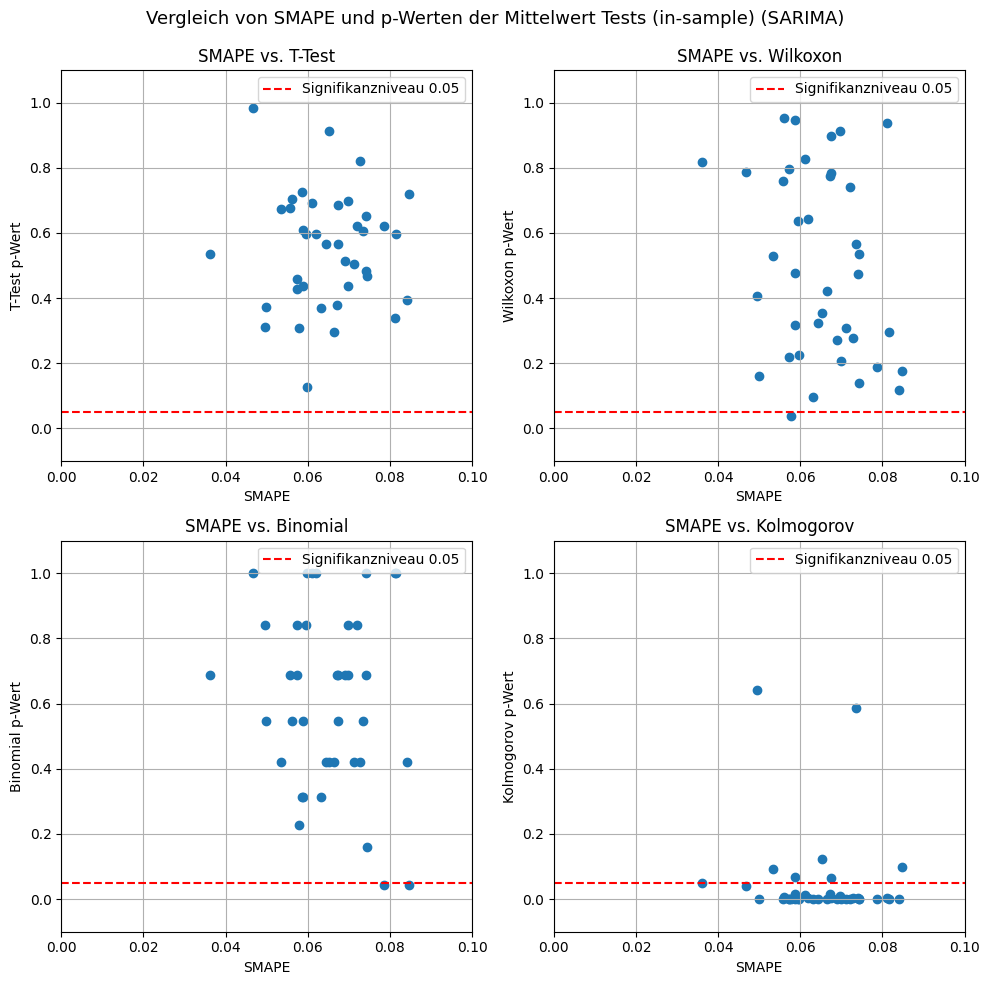

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

smape_dec = np.asarray(smape_stats) / 100
p_values_list = [t_pvalues, w_pvalues, b_pvalues, k_pvalues]
test_names = ["T-Test", "Wilkoxon", "Binomial", "Kolmogorov"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_dec, p_values_list[i])
    ax.set_xlabel('SMAPE')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'SMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
    ax.legend()
    ax.set_xlim(0, 0.1)
    ax.set_ylim(-0.1, 1.1)


fig.suptitle('Vergleich von SMAPE und p-Werten der Mittelwert Tests (in-sample) ({})'.format(model_type), fontsize=13)
plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

Kreuzvalidierung

In [14]:
#if model_type == 'SARIMA':
#    cvs = cv_SARIMA_all_stores('Walmart_Sales.csv', whichorder = 5)
#if model_type == 'Naive':
#    cvs = cv_naive_all_stores('Walmart_Sales.csv')

Errors

In [15]:
errors = cvs.groupby('store')['error']

mean_err = errors.mean()
std_err  = errors.std(ddof=0)
norm_bias = mean_err / std_err
norm_bias.replace([np.inf, -np.inf], np.nan, inplace=True)
norm_bias = norm_bias.dropna()  


plt.figure(figsize=(8, 6))
plt.boxplot(norm_bias.values, patch_artist=True, showmeans=True)
plt.title('Standardisierte Mean Errors aller Stores ({})'.format(model_type))
plt.ylabel(r'$\overline{\mathrm{error}_i}\; / \;\sigma_i$')
plt.xticks([1], ['Alle Stores'])
plt.axhline(0, ls='--', lw=0.8)
plt.show()

print("Mittelwert: ", np.mean(norm_bias.values))
print("Median: ", np.median(norm_bias.values))


NameError: name 'cvs' is not defined

In [ ]:
#errors = cvs[cvs['store'] == 1]['error']
#print(errors)
#print(len(errors))
print(len(forecast_dict[1]))


43


Korrelations Test

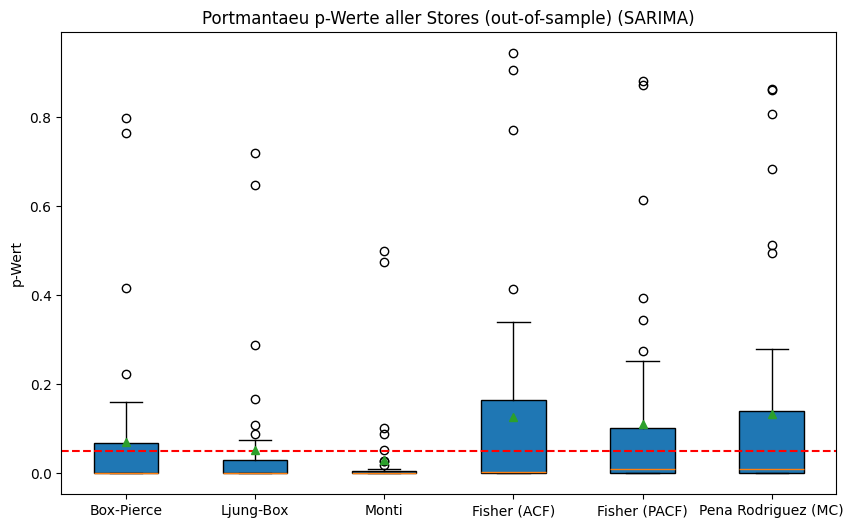

Mittelwerte: 0.07003623914178066 0.05180143751554031 0.029592943909716063 0.12597558451924903 0.10988251606187757 0.13235653235653236
Mediane: 0.0003742434377978226 4.783024935660409e-05 0.00013789371391115246 0.003527403997718448 0.010098750358013775 0.00999000999000999


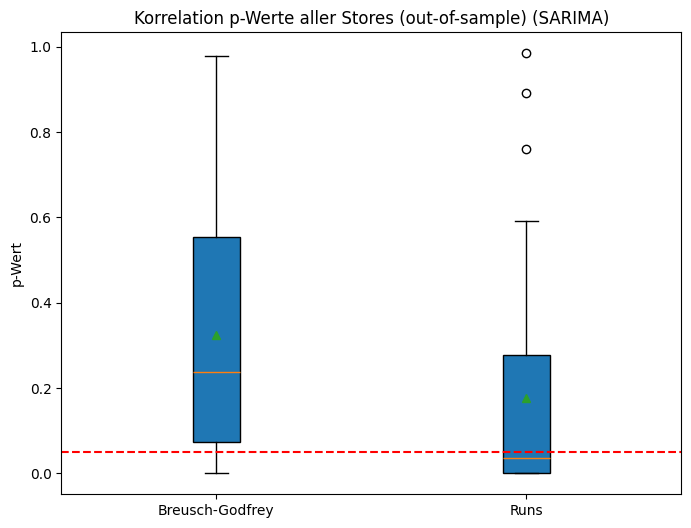

Mittelwerte: 0.32435621680596355 0.1767552254646408
Mediane: 0.237325214925727 0.035710187846911365


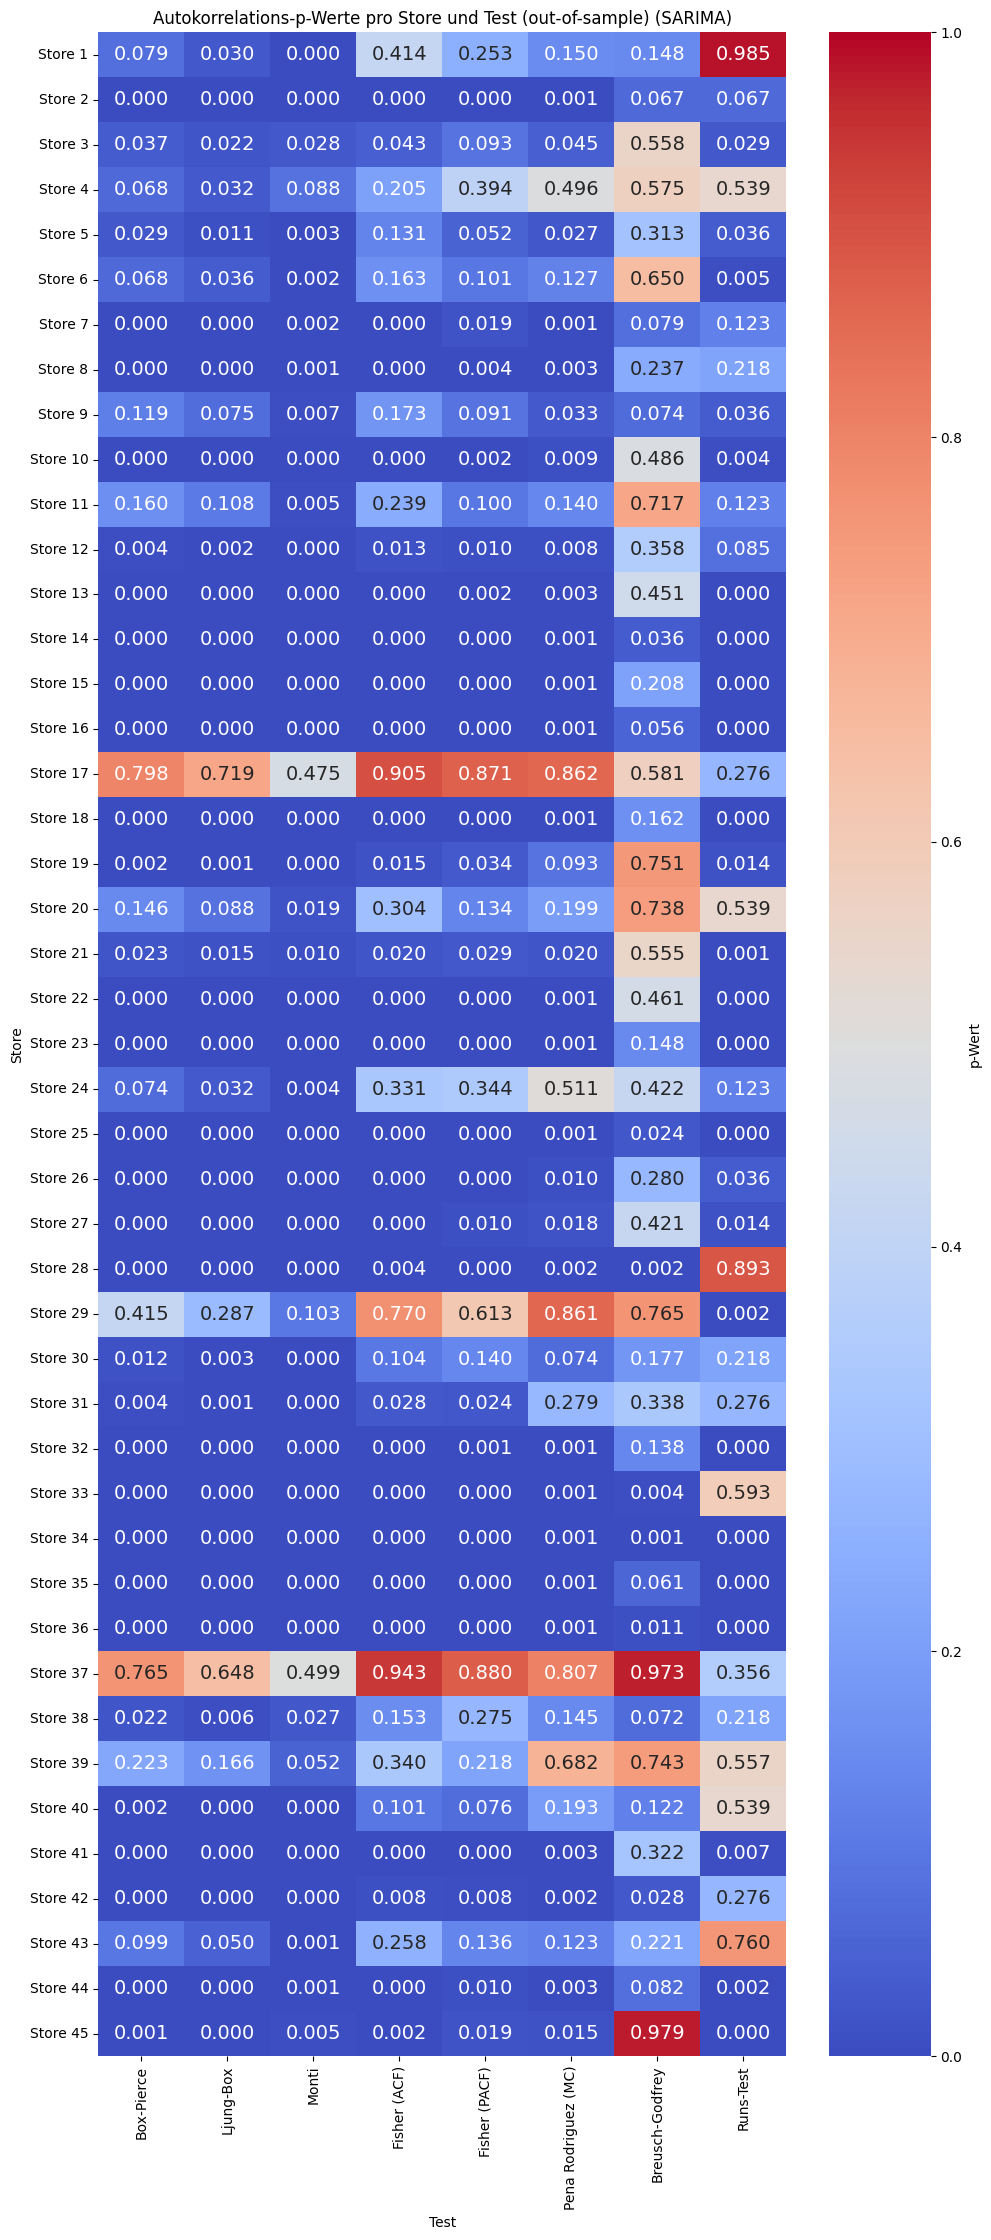

In [ ]:
bp_pvalues = []
lb_pvalues = []
bg_pvalues = []
rt_pvalues = []
m_pvalues = []
f_pvalues = []
f2_pvalues = []
pr2_pvalues = []


# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    errors = errors_dict[store]
    
    sales = df[df['store'] == store].copy() #Zeitreihe für den Store
    sales.set_index('date', inplace=True)
    sales = sales['weekly_sales']
    sales = sales.asfreq('W-FRI')

    if errors is not None:
        # Box-Pierce Test
        try:
            _, p_value = box_pierce_test(residuals = errors, store_num = store, model = model_type, sample = "OOS", lags = 10, print_results=False)
            bp_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Box-Pierce Test für Store {store}: {e}")
            bp_pvalues.append(np.nan)
        # Ljung-Box Test
        try:
            _, p_value = ljung_box_test(residuals = errors, store_num = store, model = model_type, sample = "OOS", lags = 10, print_results=False)
            lb_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Ljung-Box Test für Store {store}: {e}")
            lb_pvalues.append(np.nan)
        # Breusch-Godfrey Test
        try:
            _, p_value = breusch_godfrey_oos(residuals=errors, lags = 10)
            bg_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Breusch-Godfrey Test für Store {store}: {e}")
            bg_pvalues.append(np.nan)
        # Monti Test
        try:
            sarima_params  = optimal_orders_5.get(str(store))
            order = tuple(sarima_params["order"])
            _, p_value = monti_test(residuals = errors, store_num = store, model = model_type, m = 10, print_results = False)
            m_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Monti Test für Store {store}: {e}")
            m_pvalues.append(np.nan)
        # Fisher Test (ACF)
        try:
            sarima_params  = optimal_orders_5.get(str(store))
            order = tuple(sarima_params["order"])
            _, p_value = fisher_test(residuals = errors, store_num = store, model = model_type, version = "acf", m = 10, print_results = False)
            f_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Fisher Test für Store {store}: {e}")
            f_pvalues.append(np.nan)
        # Fisher Test (PACF)
        try:
            sarima_params  = optimal_orders_5.get(str(store))
            order = tuple(sarima_params["order"])
            _, p_value = fisher_test(residuals = errors, store_num = store, model = model_type, version = "pacf", m = 10, print_results = False)
            f2_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Fisher Test für Store {store}: {e}")
            f2_pvalues.append(np.nan)
        # Pena Rodriguez Test (Monte Carlo)
        try:
            _, p_value = pena_rodriguez_test_mc(residuals = errors, m = 10, print_results= False)
            pr2_pvalues.append(p_value)

        except Exception as e:
            print(f"Fehler beim Pena Rodriguez Test für Store {store}: {e}")
            pr2_pvalues.append(np.nan)
        # Runs Test
        try:
            _, p_value = run_test(residuals = errors, print_results=False)
            rt_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Runs Test für Store {store}: {e}")
            rt_pvalues.append(np.nan)
    else:
        bp_pvalues.append(np.nan)
        lb_pvalues.append(np.nan)
        bg_pvalues.append(np.nan)
        rt_pvalues.append(np.nan)
        m_pvalues.append(np.nan)
        f_pvalues.append(np.nan)
        f2_pvalues.append(np.nan)
        pr2_pvalues.append(np.nan)


pvalues = np.column_stack([bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr2_pvalues, bg_pvalues, rt_pvalues])
pvalues_portmantaeu = np.column_stack([bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr2_pvalues])
pvalues_other = np.column_stack([bg_pvalues, rt_pvalues])


# Boxplot Portmanteau
plt.figure(figsize=(10, 6))
plt.boxplot(pvalues_portmantaeu, patch_artist=True, showmeans=True)
plt.title('Portmantaeu p-Werte aller Stores (out-of-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4, 5, 6], ["Box-Pierce", "Ljung-Box",  "Monti", "Fisher (ACF)", "Fisher (PACF)", "Pena Rodriguez (MC)"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.show()

# Mittelwerte und Median der p-Werte
print("Mittelwerte:", np.mean(bp_pvalues), np.mean(lb_pvalues),  np.mean(m_pvalues), np.mean(f_pvalues), np.mean(f2_pvalues), np.mean(pr2_pvalues))
print("Mediane:", np.median(bp_pvalues), np.median(lb_pvalues),  np.median(m_pvalues), np.median(f_pvalues), np.median(f2_pvalues), np.median(pr2_pvalues))


# Boxplot Breusch-Godfrey und Runs-Test
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues_other, patch_artist=True, showmeans=True)
plt.title('Korrelation p-Werte aller Stores (out-of-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2], ["Breusch-Godfrey", "Runs"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.show()

# Mittelwerte und Median der p-Werte
print("Mittelwerte:", np.mean(bg_pvalues), np.mean(rt_pvalues))
print("Mediane:", np.median(bg_pvalues), np.median(rt_pvalues))


# Heatmap
store_names = [f"Store {i+1}" for i in range(pvalues.shape[0])]
columns = ["Box-Pierce", "Ljung-Box",  "Monti", "Fisher (ACF)", "Fisher (PACF)", "Pena Rodriguez (MC)", "Breusch-Godfrey", "Runs-Test"]
df_pvalues = pd.DataFrame(pvalues, index=store_names, columns=columns)
plt.figure(figsize=(10, len(store_names) * 0.5))  # Dynamische Höhe
sns.heatmap(df_pvalues, annot=True, fmt=".3f", annot_kws={"size": 14}, cmap="coolwarm", cbar_kws={'label': 'p-Wert'}, vmin=0, vmax=1)
plt.title('Autokorrelations-p-Werte pro Store und Test (out-of-sample) ({})'.format(model_type))
plt.xlabel("Test")
plt.ylabel("Store")
plt.tight_layout()
plt.show()


Durbin Watson

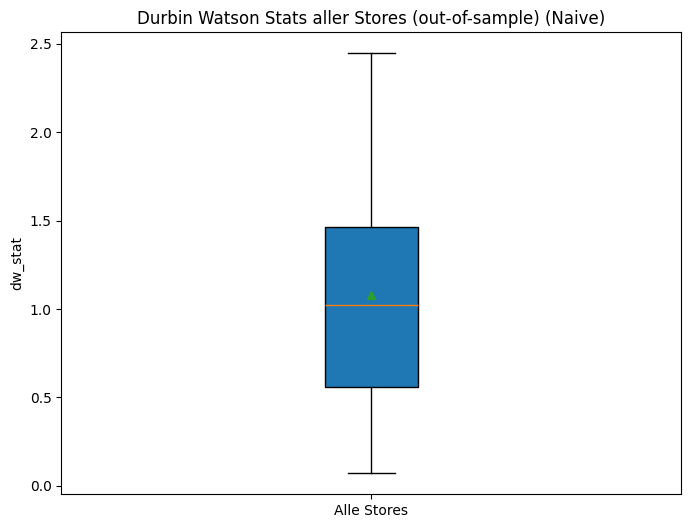

Mittelwert: 1.0788103891018517
Median: 1.024739746960642


In [ ]:
dw_stats = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    error = cvs[cvs['store'] == store]['error']
    if resid is not None:
        try:
            dw_stat = durbin_watson_test(error, False)
            dw_stats.append(dw_stat)
        except Exception as e:
            print(f"Fehler beim Durbin Watson Test für Store {store}: {e}")
            dw_stats.append(np.nan)
    else:
        dw_stats.append(np.nan)

# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(dw_stats, patch_artist=True, showmeans=True)
plt.title('Durbin Watson Stats aller Stores (out-of-sample) ({})'.format(model_type))
plt.ylabel("dw_stat")
plt.xticks([1], ["Alle Stores"])
plt.show()

print("Mittelwert:", np.mean(dw_stats))
print("Median:", np.median(dw_stats))


Mittelwert Tests

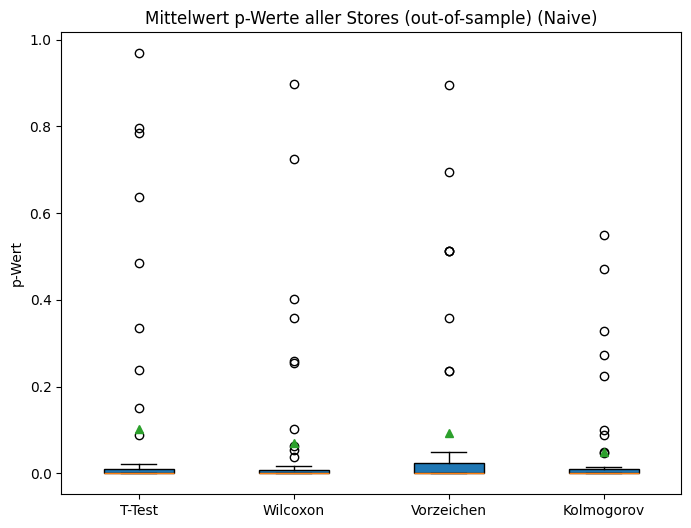

Mittelwerte: 0.1012736734662184 0.07082620723626222 0.09174923735287488 0.04839594110975701
Mediane: 1.0068428804593193e-05 8.66820339270204e-06 3.011590962911926e-05 2.5422285445180095e-05


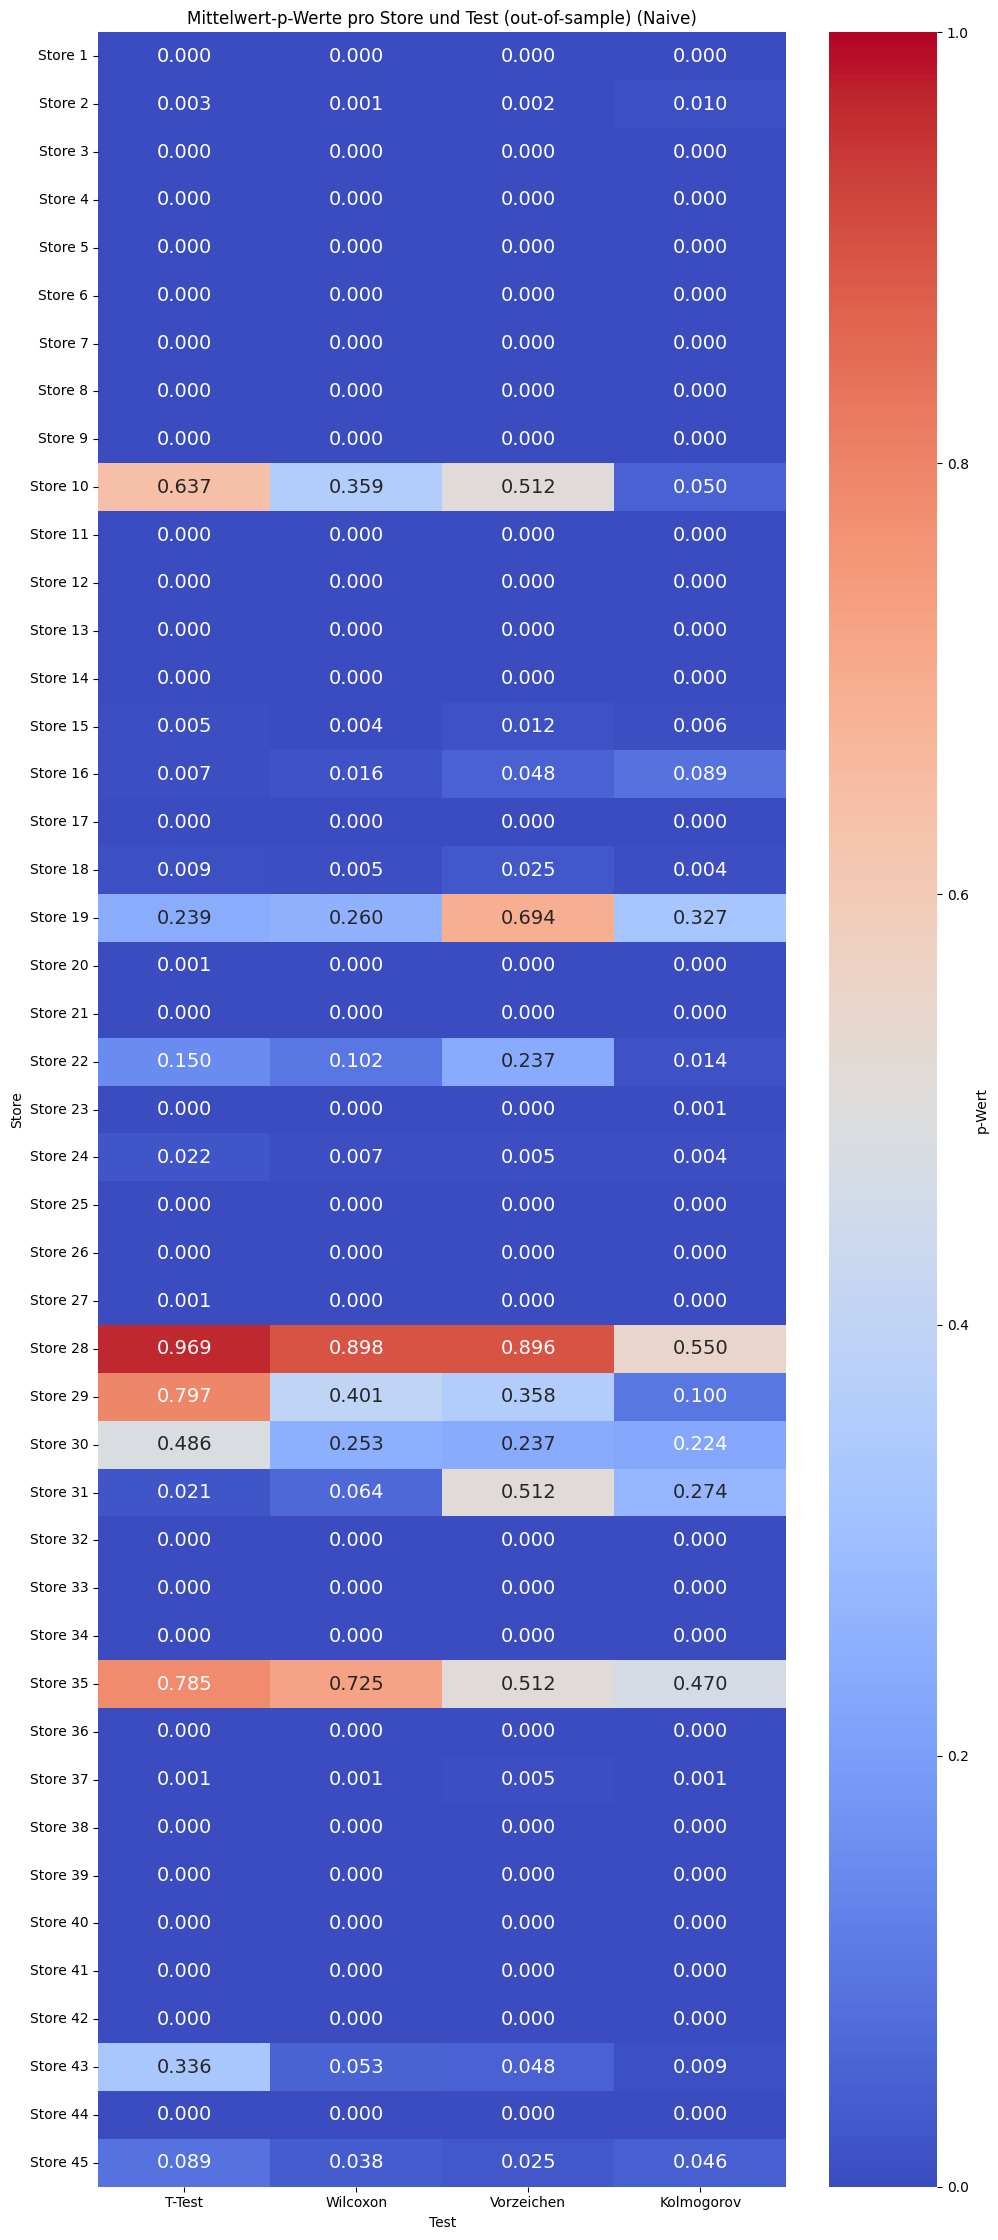

In [ ]:
t_pvalues = []
w_pvalues = []
b_pvalues = []
k_pvalues = []
z_pvalues = []
s_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    errors = cvs[cvs['store'] == store]['error']
    if resid is not None:
        # T-Test
        try:
            _, p_value = t_test(errors, False)
            t_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim t-Test für Store {store}: {e}")
            t_pvalues.append(np.nan)
        # Wilcoxon Test
        try:
            _, p_value = wilcoxon_test(errors, False)
            w_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Wilcoxon Test für Store {store}: {e}")
            w_pvalues.append(np.nan)
        # Binomial Test
        try:
            _, _, p_value = binomial_test(errors, False)
            b_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Binomial Test für Store {store}: {e}")
            b_pvalues.append(np.nan)
        # Sign Test
        try:
            _, s_value = vorzeichen_test(errors, False)
            s_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Sign Test für Store {store}: {e}")
            s_pvalues.append(np.nan)
        # Kolmogorov Test
        try:
            _, p_value = kolmogorov_test(errors, False)
            k_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Kolmogorov Test für Store {store}: {e}")
            k_pvalues.append(np.nan)
        # Z-Test
        try:
            _, p_value = z_test(errors, False)
            z_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Z-Test für Store {store}: {e}")
            z_pvalues.append(np.nan)
    else:
        t_pvalues.append(np.nan)
        w_pvalues.append(np.nan)
        b_pvalues.append(np.nan)
        k_pvalues.append(np.nan)
        z_pvalues.append(np.nan)


pvalues = np.column_stack([t_pvalues, w_pvalues, s_pvalues, k_pvalues])


# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues, patch_artist=True, showmeans=True)
plt.title('Mittelwert p-Werte aller Stores (out-of-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4], ["T-Test", "Wilcoxon", "Vorzeichen", "Kolmogorov"])
plt.show()

# Mittelwerte und Median der p-Werte
print("Mittelwerte:", np.mean(t_pvalues), np.mean(w_pvalues), np.mean(s_pvalues),np.mean(k_pvalues))
print("Mediane:", np.median(t_pvalues), np.median(w_pvalues), np.median(s_pvalues), np.median(k_pvalues))

# Heatmap
store_names = [f"Store {i+1}" for i in range(pvalues.shape[0])]
columns = ["T-Test", "Wilcoxon", "Vorzeichen", "Kolmogorov"]
df_pvalues = pd.DataFrame(pvalues, index=store_names, columns=columns)
plt.figure(figsize=(10, len(store_names) * 0.5))  # Dynamische Höhe
sns.heatmap(df_pvalues, annot=True, fmt=".3f", annot_kws={"size": 14}, cmap="coolwarm", cbar_kws={'label': 'p-Wert'}, vmin=0, vmax=1)
plt.title('Mittelwert-p-Werte pro Store und Test (out-of-sample) ({})'.format(model_type))
plt.xlabel("Test")
plt.ylabel("Store")
plt.tight_layout()
plt.show()


SMAPE

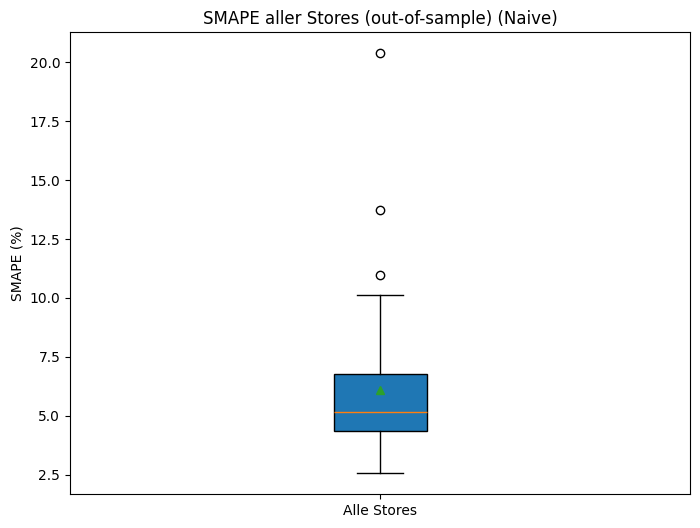

Mittelwert: 6.088989717718031 %
Median: 5.150058108888672 %


In [ ]:
smape_stats = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    forecast_values = cvs[cvs['store'] == store]['forecast']
    actual_values = cvs[cvs['store'] == store]['actual']

    if len(forecast_values) > 0:
        # SMAPI Test
    
        numerator = np.abs(forecast_values - actual_values)
        denominator = (np.abs(forecast_values) + np.abs(actual_values)) / 2
        smape = np.where(denominator == 0, 0, numerator / denominator)
        smape = np.mean(smape) * 100
        try:
            smape_stats.append(smape)
        except Exception as e:
            print(f"Fehler beim SMAPI Test für Store {store}: {e}")
            smape_stats.append(np.nan)
    else:
        smape_stats.append(np.nan)

plt.figure(figsize=(8, 6))
plt.boxplot(smape_stats, patch_artist=True, showmeans=True)
plt.title('SMAPE aller Stores (out-of-sample) ({})'.format(model_type))
plt.ylabel("SMAPE (%)")
plt.xticks([1], ["Alle Stores"])
plt.show()

# Mittelwerte und Median der SMAPE Werte
print("Mittelwert:", np.mean(smape_stats), "%")
print("Median:", np.median(smape_stats), "%")

SMAPE vs. Autokorrelation p-Werte

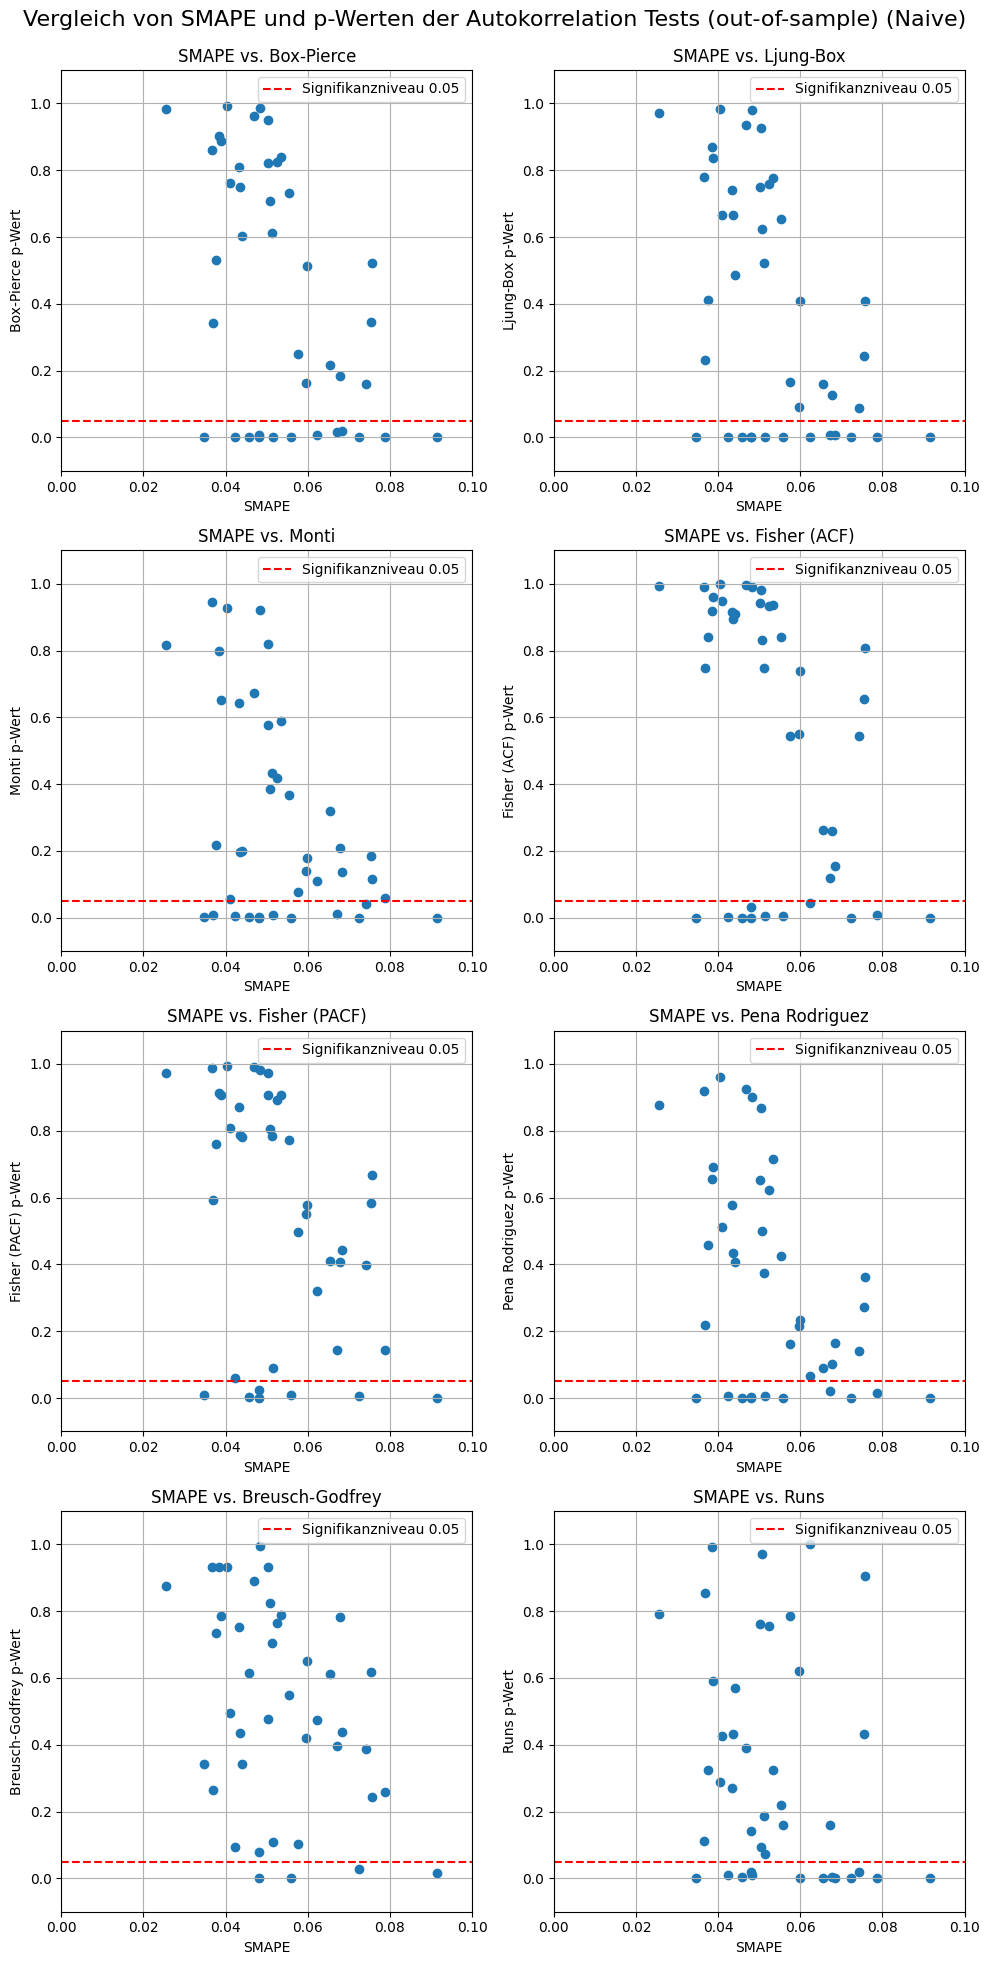

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))

smape_dec = np.asarray(smape_stats) / 100
p_values_list = [bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr2_pvalues, bg_pvalues, rt_pvalues]
test_names = ["Box-Pierce", "Ljung-Box", "Monti", "Fisher (ACF)", "Fisher (PACF)", "Pena Rodriguez", "Breusch-Godfrey", "Runs"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_dec, p_values_list[i])
    ax.set_xlabel('SMAPE')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'SMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
    ax.legend()
    ax.set_xlim(0, 0.1)
    ax.set_ylim(-0.1, 1.1)


fig.suptitle('Vergleich von SMAPE und p-Werten der Autokorrelation Tests (out-of-sample) ({})'.format(model_type), fontsize=16)
plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

SMAPE vs. Mittelwert p-Werte

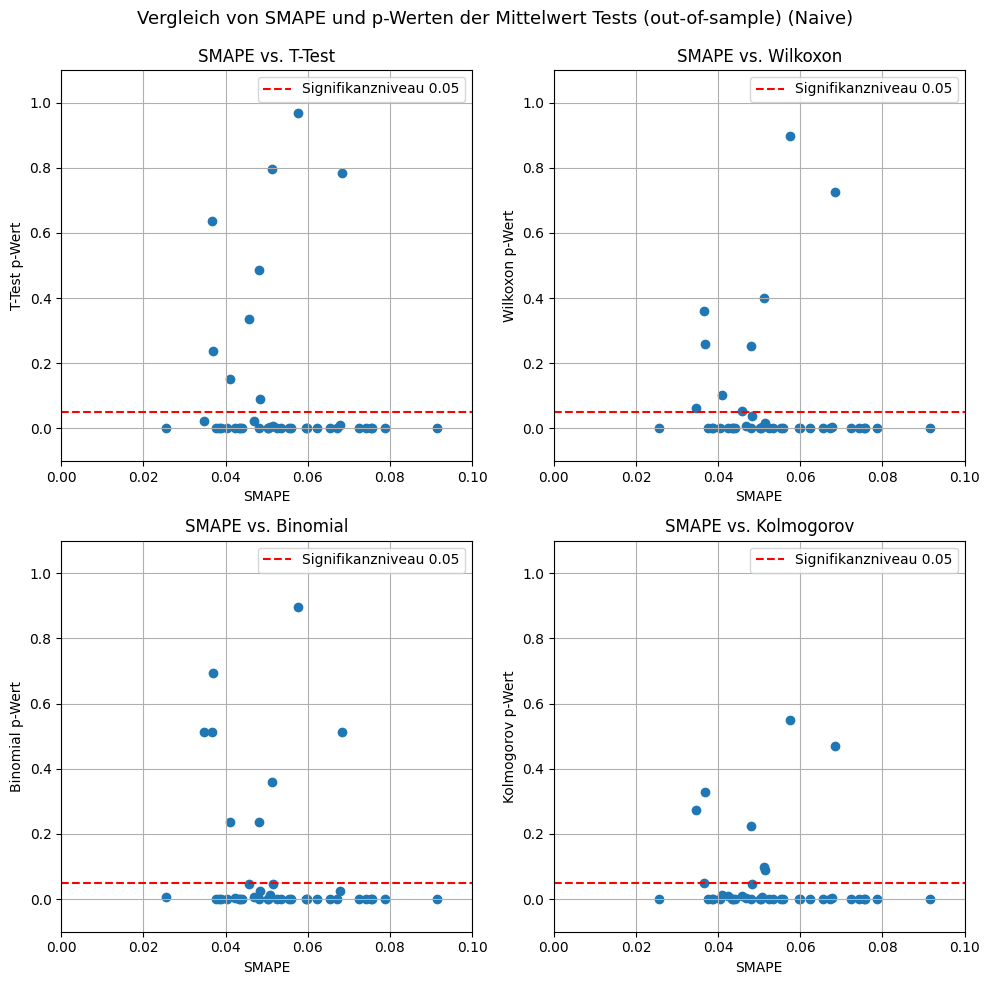

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

smape_dec = np.asarray(smape_stats) / 100
p_values_list = [t_pvalues, w_pvalues, b_pvalues, k_pvalues]
test_names = ["T-Test", "Wilkoxon", "Binomial", "Kolmogorov"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_dec, p_values_list[i])
    ax.set_xlabel('SMAPE')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'SMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
    ax.legend()
    ax.set_xlim(0, 0.1)
    ax.set_ylim(-0.1, 1.1)


fig.suptitle('Vergleich von SMAPE und p-Werten der Mittelwert Tests (out-of-sample) ({})'.format(model_type), fontsize=13)
plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()